# Plot violated constraints on uncertain parameter space

Recreate Ander's figure 5.

In [27]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
from typing import List
import numpy as np
import seaborn as sns

## Plot facet with synthetic data
Try to create a contour plot using simple synthetic data.

In [28]:
# Seaborn plots nice facetgrids, but only for density: can't plot w, ineq_1, ineq_2 on same plot
# Quite custom: use matplotlib here


def plot_facet(
    data: pd.DataFrame,
    x_param: str,
    y_param: str,
    cons: List[str],
    fig: matplotlib.figure.Figure,
    ax: matplotlib.axes._axes.Axes,
    smooth: bool = False,
):
    x = data[x_param]
    y = data[y_param]

    # Plot safe and failure domains (c<0, c>0) for each constraint
    for con in cons:
        z = data[con]
        xyz = np.stack((x, y, z), axis=1)

        # Different colours for different constraints
        # Show w safe, hide w fail. Hide other con safe, show other con fail
        # Set alphas for individual cons
        con_alpha = 0.5
        con_colours = {
            "z": ["blue", "red"],  # for testing with synthetic data
            "w": ["darkblue", "None"],
            "ineq_con015": ["None", ("purple", con_alpha)],
            "ineq_con016": ["None", ("darkorange", con_alpha)],
        }

        if not smooth:
            # Contour for triangulated surface
            # Works fine, can be rough for low samples
            contour_set = ax.tricontourf(
                xyz[:, 0],
                xyz[:, 1],
                xyz[:, 2],
                colors=con_colours[con],
                levels=[-1000, 0.0, 1000],
                alpha=0.5,
            )
            # fig.colorbar(contour_set)
        else:
            # Interpolate
            # Can help smooth for sparse data
            triang = matplotlib.tri.Triangulation(xyz[:, 0], xyz[:, 1])
            refiner = matplotlib.tri.UniformTriRefiner(triang)
            tri_refi, z_refi = refiner.refine_field(xyz[:, 2], subdiv=3)
            contour_set = ax.tricontourf(
                tri_refi,
                z_refi,
                colors=con_colours[con],
                levels=[-1000, 0.0, 1000],
                alpha=0.5,
            )
            # fig.colorbar(contour_set)

        # Scatter to see actual data
        # Bin constraints into violated or satisfied
        z_bin = z.to_numpy(copy=True)
        z_bin[z_bin <= 0] = 0
        z_bin[z_bin > 0] = 1
        cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
            name="binary_map", colors=["blue", "red"], N=2
        )
        ax.scatter(x=x, y=y, c=z_bin, cmap=cmap, alpha=0.5, s=14)

    ax.set_xlabel(x_param)
    ax.set_ylabel(y_param)
    ax.set_title("Violated constraints in uncertain parameter space")

Attempt simple plot with clearly-contoured data: distinct safe/failure regions.

In [29]:
def simple_con(x: np.ndarray, y: np.ndarray, jitter: np.ndarray) -> np.ndarray:
    z = x**2 - y + jitter
    return z


sample_count = 500
rng = np.random.default_rng()
params = rng.uniform(size=(sample_count, 2))
jitter_amount = 0.2
jitter = rng.uniform(low=-jitter_amount, high=jitter_amount, size=sample_count)
responses = simple_con(x=params[:, 0], y=params[:, 1], jitter=jitter)
samples = np.concatenate(
    (params, jitter[:, np.newaxis], responses[:, np.newaxis]), axis=1
)
test_lt_df = pd.DataFrame(samples, columns=["x", "y", "jitter", "z"])
test_lt_df

,x,y,jitter,z
0,0.488573,0.338660,-0.078866,-0.178822
1,0.436290,0.094889,0.039391,0.134851
2,0.243472,0.293106,-0.189087,-0.422913
3,0.690781,0.643954,-0.167840,-0.334616
4,0.587212,0.834294,-0.197482,-0.686958
...,...,...,...,...
495,0.742196,0.873153,0.163540,-0.158758
496,0.851119,0.328115,0.137473,0.533762
497,0.688642,0.812153,0.086427,-0.251499
498,0.831187,0.837063,0.081144,-0.065047


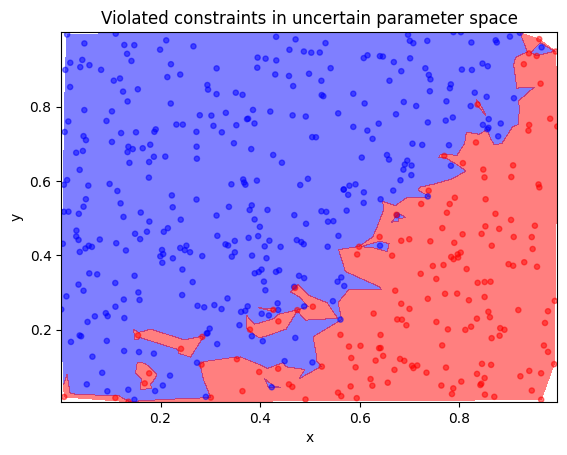

In [30]:
fig, ax = plt.subplots()
plot_facet(data=test_lt_df, x_param="x", y_param="y", cons=["z"], fig=fig, ax=ax)
# Simple con looks ok with tricontourf, no interpolation
# holes in refined one: need to filter after refinement? Some values <0 or >1
# Try without binning: just use actual values and bin with contour levels in plot
# Much smoother: looks good
# Try adding jitter to blur the boundary: does this help?
# Regular plot: some islands, rough

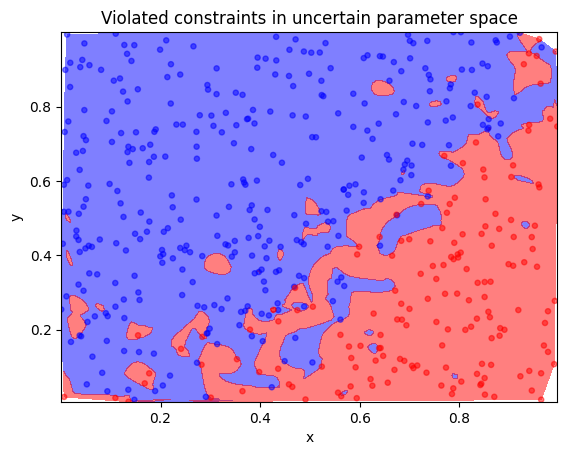

In [31]:
# Add smoothing
fig, ax = plt.subplots()
plot_facet(
    data=test_lt_df, x_param="x", y_param="y", cons=["z"], fig=fig, ax=ax, smooth=True
)

Smoothing is quite chaotic: perhaps mixing of safe/failure distributions is causing this.

## Plot real data
Use LT $\max R_{major}$ data.

In [32]:
lt_df = pd.read_csv("lt/ps_lt_3p.dat", delimiter="\s+")
lt_df = lt_df.drop(columns=[r"%eval_id", "interface"])
lt_df

,fimp_14,ralpne,kappa,fdene,hfact,coreradius,psepbqarmax,flhthresh,cboot,peakfactrad,...,ineq_con065,ineq_con072,ineq_con081,ineq_con068,ineq_con031,ineq_con032,ineq_con005,ineq_con008,ineq_con009,ineq_con013
0,0.000066,0.090216,1.872164,1.2,1.190797,0.75,9.7,1,1,3.33,...,-1.643351,-0.005158,-0.624360,-1.138920,-1.132427e-14,-0.006766,-0.023824,-0.790867,-0.670453,0.066193
1,0.000084,0.086114,1.824173,1.2,1.190797,0.75,9.7,1,1,3.33,...,-1.679822,-0.005632,-0.738768,-1.849240,-1.132427e-14,-0.006766,0.026777,-0.710167,-0.621591,0.032991
2,0.000077,0.109027,1.814204,1.2,1.190797,0.75,9.7,1,1,3.33,...,-1.687523,-0.005738,-0.763309,-5.129898,-1.132427e-14,-0.006766,0.036987,-0.914969,-0.822014,0.030255
3,0.000061,0.093954,1.818333,1.2,1.190797,0.75,9.7,1,1,3.33,...,-1.684327,-0.005693,-0.753109,-1.047702,-1.132427e-14,-0.006766,0.032770,-0.768409,-0.680182,0.007664
4,0.000062,0.112687,1.883999,1.2,1.190797,0.75,9.7,1,1,3.33,...,-1.634505,-0.005051,-0.597068,-2.877592,-1.132427e-14,-0.006766,-0.036683,-1.029205,-0.885147,0.087919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.000082,0.090709,1.824853,1.2,1.190797,0.75,9.7,1,1,3.33,...,-1.679298,-0.005624,-0.737104,-2.141866,-1.132427e-14,-0.006766,0.026077,-0.750885,-0.659813,0.034454
996,0.000042,0.092792,1.844018,1.2,1.190797,0.75,9.7,1,1,3.33,...,-1.664621,-0.005428,-0.690719,-0.462138,-1.132427e-14,-0.006766,0.006148,-0.778809,-0.675243,0.013351
997,0.000054,0.112019,1.810649,1.2,1.190797,0.75,9.7,1,1,3.33,...,-1.690280,-0.005776,-0.772125,-1.810895,-1.132427e-14,-0.006766,0.040603,-0.935422,-0.843724,0.004175
998,0.000073,0.102187,1.878010,1.2,1.190797,0.75,9.7,1,1,3.33,...,-1.638975,-0.005105,-0.610835,-2.947093,-1.132427e-14,-0.006766,-0.030156,-0.914776,-0.782475,0.087141


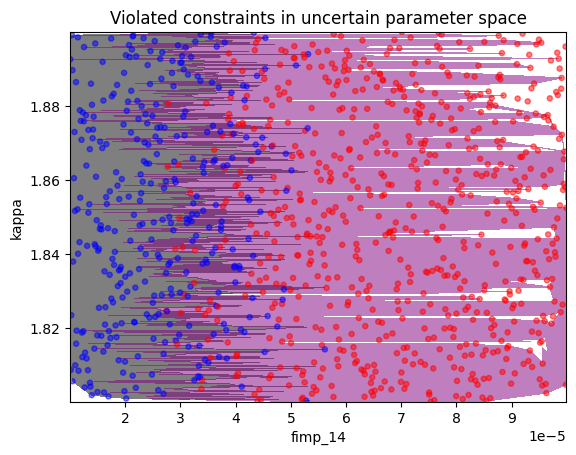

In [33]:
# Plot one facet (pair of uncertain params)
# 15 good, 30 bad, 16 ok, 5 bad, 13 ok
# plot_facet(data=lt_df, x_param="fimp_14", y_param="ralpne", cons=["ineq_con016"])
fig, ax = plt.subplots()
plot_facet(
    data=lt_df,
    x_param="fimp_14",
    y_param="kappa",
    # cons=["w", "ineq_con015", "ineq_con016"],
    cons=["ineq_con015"],
    fig=fig,
    ax=ax,
)

# TODO Need to plot hyperbox
# TODO Analyse which cons are ever > 0: that's what is interesting to plot
# Perhaps contours aren't that helpful: not "nice" funcs like in Ander's paper
# Just plot scatter (seaborn)?

Contour plots generally appear very rough/noisy: possibly due to complexity of interactions between uncertain parameters and constraints, and uncertain parameters beyond the 2D projection (joint distribution). Can't seem to recreate Ander's neat contour plots, and some simple smoothing doesn't really help.

## Seaborn pairplots
Give up on contours, get a feel with seaborn's pairplots instead.

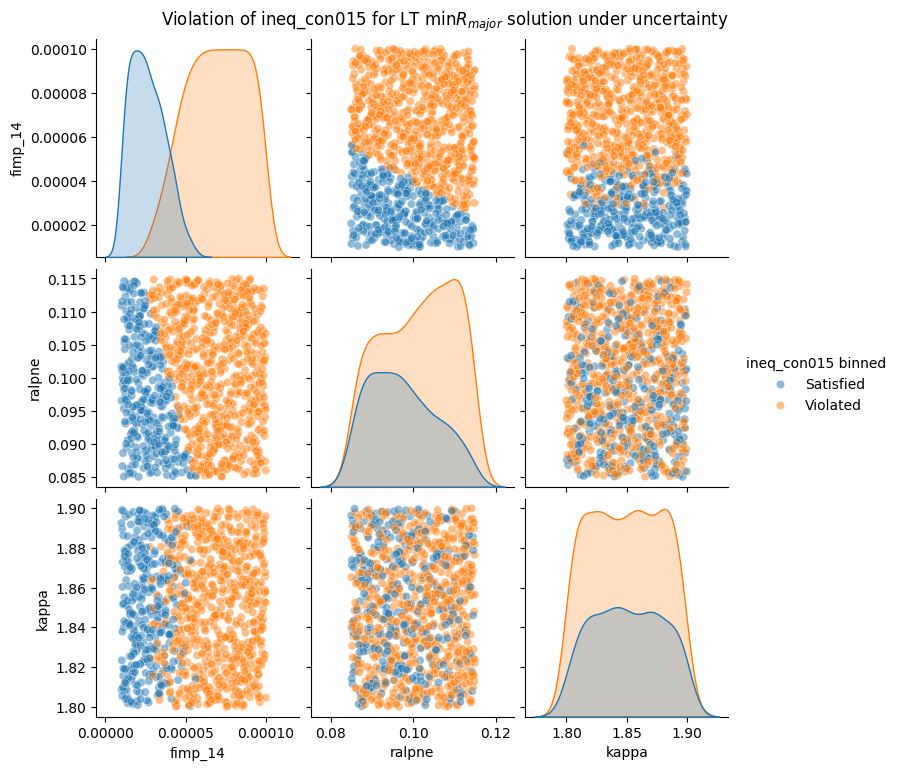

In [34]:
def single_con_pairplot(data: pd.DataFrame, params: List[str], con: str, title: str):
    # Extract uncertain params and cons
    samples = data[params + [con]]

    # Bin w values to categorise
    z = samples[con].to_numpy(copy=True)
    z_str = np.empty_like(z, dtype=np.dtype("U10"))
    z_str[z <= 0] = "Satisfied"
    z_str[z > 0] = "Violated"

    con_binned = f"{con} binned"
    samples_binned = pd.concat([samples, pd.DataFrame({con_binned: z_str})], axis=1)

    g = sns.pairplot(
        data=samples_binned[params + [con_binned]],
        hue=con_binned,
        plot_kws={"alpha": 0.5},
        hue_order=["Satisfied", "Violated"],
    )
    g.figure.suptitle(
        title,
        y=1.02,
    )
    return g


single_con_pairplot(
    data=lt_df,
    params=["fimp_14", "ralpne", "kappa"],
    con="ineq_con015",
    title="Violation of ineq_con015 for LT $\min R_{major}$ solution under uncertainty",
)

Shows which uncertain params are violating constraint 15 (LH threshold). Some useful information about which constraints are being violated by which uncertain params.

What about w?

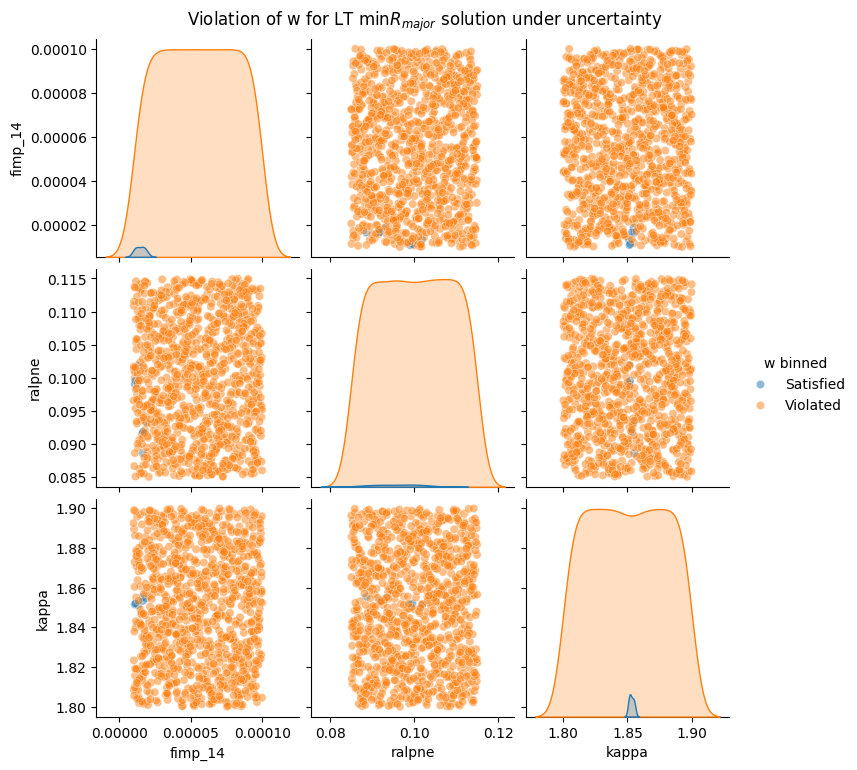

In [35]:
single_con_pairplot(
    data=lt_df,
    params=["fimp_14", "ralpne", "kappa"],
    con="w",
    title="Violation of w for LT $\min R_{major}$ solution under uncertainty",
)

What about multiple constraints (like Ander's plot)? Add in con 16 (net electric power lower limit) and 68 (divertor protection factor).

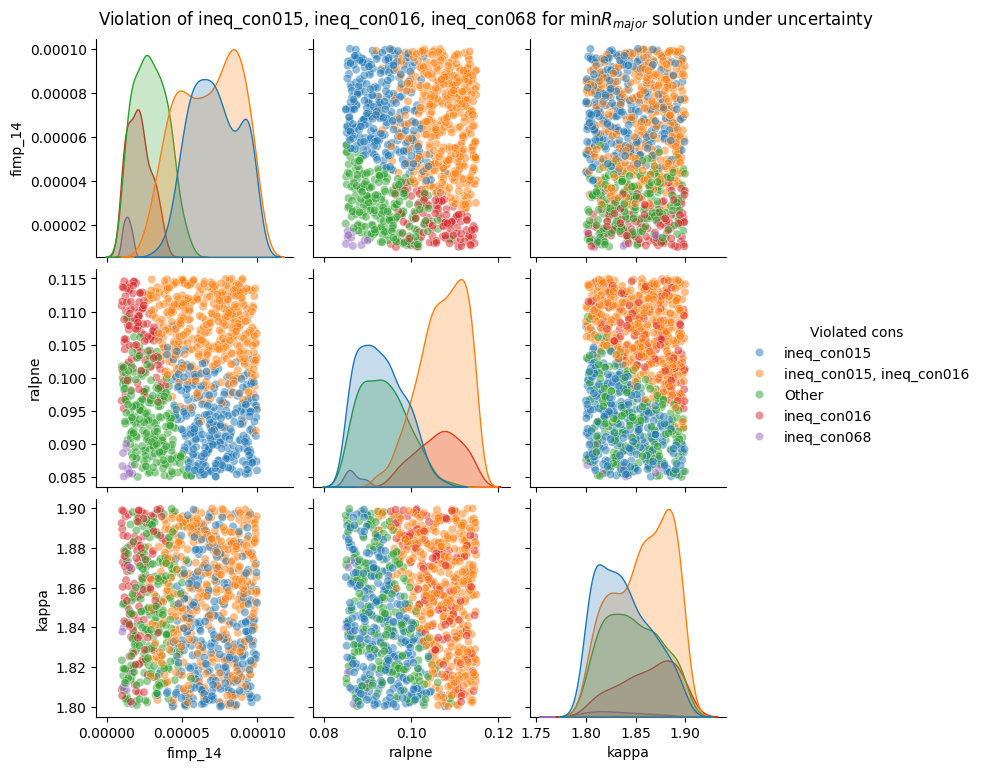

In [36]:
def multi_cons_pairplot(
    data: pd.DataFrame, params: List[str], cons: List[str], title: str
):
    # Extract uncertain params and cons
    samples = data[params + cons]

    # Find violated constraints
    # Apply >0 boolean mask to column indexes
    vio_cons = (
        samples[cons].gt(0.0).apply(lambda x: ", ".join((x.index[x].tolist())), axis=1)
    )
    vio_cons[vio_cons == ""] = "Other"
    vio_cons_col_name = "Violated cons"
    vio_cons.name = vio_cons_col_name
    samples = pd.concat((samples, vio_cons), axis=1)
    samples

    g = sns.pairplot(
        data=samples[params + [vio_cons_col_name]],
        hue=vio_cons_col_name,
        plot_kws={"alpha": 0.5},
        # hue_order=["Satisfied", "Violated"],
    )
    g.figure.suptitle(title, y=1.02)


cons = ["ineq_con015", "ineq_con016", "ineq_con068"]
multi_cons_pairplot(
    data=lt_df,
    params=["fimp_14", "ralpne", "kappa"],
    cons=["ineq_con015", "ineq_con016", "ineq_con068"],
    title=f"Violation of {', '.join(cons)}"
    + " for $\min R_{major}$ solution under uncertainty",
)

## Compare with lt_max_q data

In [37]:
lt_max_q_df = pd.read_csv("lt_max_q/ps_lt_max_q_3p.dat", delimiter="\s+")
lt_max_q_df = lt_max_q_df.drop(columns=[r"%eval_id", "interface"])
lt_max_q_df

,fimp_14,ralpne,kappa,fdene,hfact,coreradius,psepbqarmax,flhthresh,cboot,peakfactrad,...,ineq_con065,ineq_con072,ineq_con081,ineq_con068,ineq_con031,ineq_con032,ineq_con005,ineq_con008,ineq_con009,ineq_con013
0,0.000071,0.102584,1.822666,1.2,1.2,0.75,9.7,1,1,3.33,...,-1.845272,-0.546892,-0.742809,-3.826020,-0.086745,-0.079734,0.028474,-0.390966,-0.042555,-0.064660
1,0.000021,0.106115,1.883694,1.2,1.2,0.75,9.7,1,1,3.33,...,-1.793815,-0.545158,-0.598099,-0.561142,-0.086745,-0.079734,-0.036191,-0.455562,-0.068442,-0.038431
2,0.000074,0.090377,1.878616,1.2,1.2,0.75,9.7,1,1,3.33,...,-1.798027,-0.545293,-0.609770,-2.475647,-0.086745,-0.079734,-0.030659,-0.346483,0.009916,0.000707
3,0.000069,0.098921,1.805914,1.2,1.2,0.75,9.7,1,1,3.33,...,-1.859725,-0.547412,-0.784279,-1.892830,-0.086745,-0.079734,0.045543,-0.351228,-0.018617,-0.089808
4,0.000092,0.097547,1.847737,1.2,1.2,0.75,9.7,1,1,3.33,...,-1.823910,-0.546149,-0.682173,-156277.443200,-0.086745,-0.079734,0.002387,-0.377648,-0.023738,-0.015565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.000064,0.094884,1.874209,1.2,1.2,0.75,9.7,1,1,3.33,...,-1.801693,-0.545411,-0.619954,-2.022973,-0.086745,-0.079734,-0.025879,-0.372913,-0.011036,-0.012216
996,0.000075,0.098508,1.870284,1.2,1.2,0.75,9.7,1,1,3.33,...,-1.804966,-0.545518,-0.629065,-6.141812,-0.086745,-0.079734,-0.021640,-0.398679,-0.031390,-0.004607
997,0.000064,0.103547,1.860759,1.2,1.2,0.75,9.7,1,1,3.33,...,-1.812939,-0.545780,-0.651339,-4.238682,-0.086745,-0.079734,-0.011424,-0.426536,-0.055358,-0.024524
998,0.000064,0.101795,1.869372,1.2,1.2,0.75,9.7,1,1,3.33,...,-1.805727,-0.545543,-0.631187,-3.847333,-0.086745,-0.079734,-0.020658,-0.420310,-0.047667,-0.014218


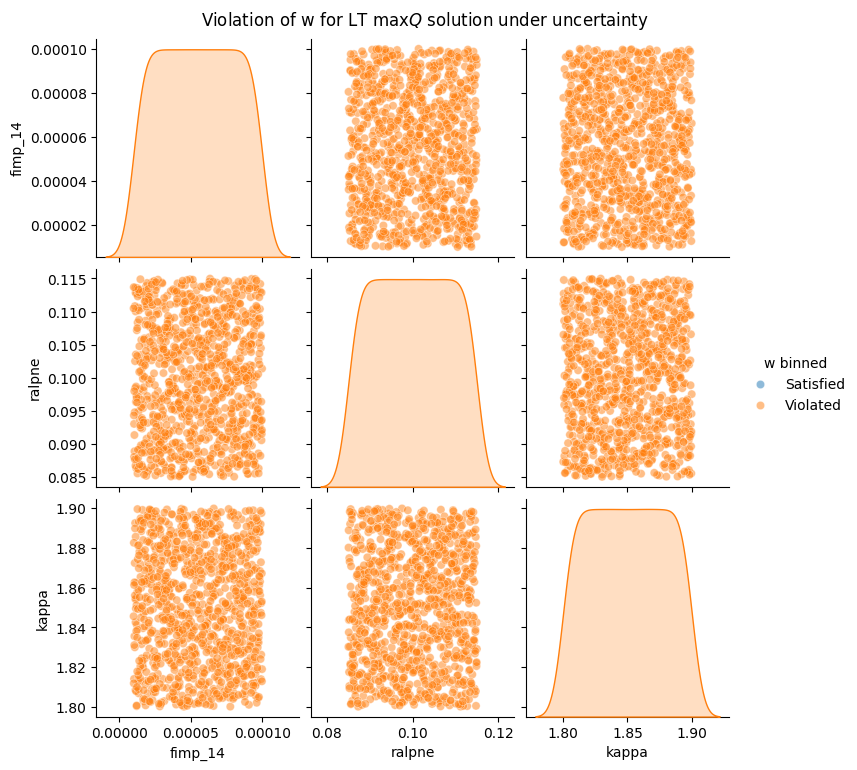

In [38]:
single_con_pairplot(
    data=lt_max_q_df,
    params=["fimp_14", "ralpne", "kappa"],
    con="w",
    title="Violation of w for LT $\max Q$ solution under uncertainty",
)

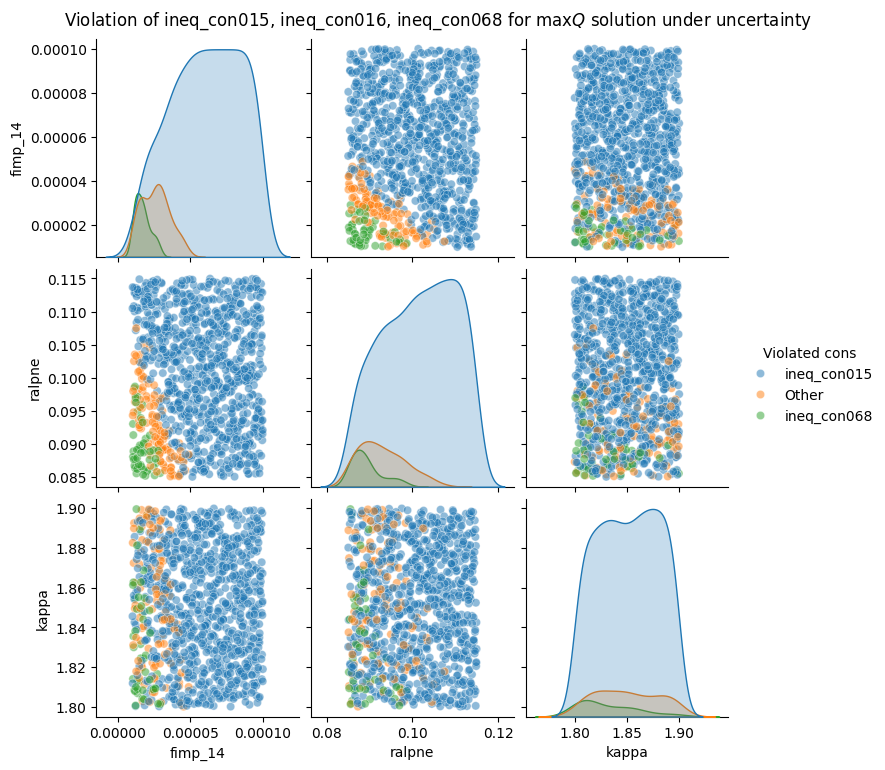

In [39]:
multi_cons_pairplot(
    data=lt_max_q_df,
    params=["fimp_14", "ralpne", "kappa"],
    cons=["ineq_con015", "ineq_con016", "ineq_con068"],
    title=f"Violation of {', '.join(cons)}"
    + " for $\max Q$ solution under uncertainty",
)

Multiple constraints plots show clear difference between design points: $\max Q$'s uncertain parameter space is dominated by constraint 15 (LH threshold) violations, whereas $\min R_{major}$ has a more mixed picture, with constraint 16 (min net electric) and others being violated too. This is useful when visualising/comparing design points under uncertainty, and could be used to show the improvement in an OUU solution.